In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

# On va chercher les données dans le fichier CSV
data = pd.read_csv('./data/train.csv')

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labels = ['toxic']

# On va séparer les données en deux parties : les commentaires et les labels
X = data['comment_text']
y = data[labels]

# On va séparer les données en deux parties : une pour l'entraînement et une pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Déterminons le meilleur max_len basé sur la longueur des commentaires
X_train.str.split().apply(len).describe()

# 75% des commentaires ont moins de 75 mots

count    127656.000000
mean         67.483785
std          99.710637
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_text, dtype: float64

In [ ]:
# On définit les paramètres, max_words est le nombre de mots maximum que l'on va garder, max_len est la longueur maximale d'un commentaire.
max_words = 20000
max_len = 100
embedding_dim = 75

# Ici le tokenizer va transformer les commentaires en séquences de nombres.
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# On va ajouter des 0 pour que toutes les séquences aient la même longueur.
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# On va utiliser un algorithme de sous-échantillonnage pour équilibrer les classes.
X_resampled_list = []
y_resampled_list = []

for label in labels:
  X_res, y_res = RandomUnderSampler().fit_resample(X_train_pad, y_train[label])
  X_resampled_list.append(X_res)
  y_resampled_list.append(y_res)
  
X_resampled = np.concatenate(X_resampled_list, axis=0)
y_resampled = np.concatenate(y_resampled_list, axis=0)

In [43]:
# Charger les embeddings GloVe
embeddings_index = {}
with open('./data/weights/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Créer une matrice d'embeddings
embeddings_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [44]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    embedding_dim,
                    weights=[embeddings_matrix],
                    input_length=max_len,
                    input_shape=(max_len,),
                    trainable=False))
model.add(GlobalAveragePooling1D())
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(75, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# On compile le modèle avec une loss binary_crossentropy, un optimizer adam et une métrique accuracy.
# On utilise binary_crossentropy car on a un problème de classification binaire, en gros on veut prédire si un commentaire est toxique ou non.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/opt/anaconda3/envs/ai/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/opt/anaconda3/envs/ai/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 50, 100)        │    18,319,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 300)            │        30,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,406,651 (70.22 MB)

 Trainable params: 86,851 (339.26 KB)

 Non-trainable params: 18,319,800 (69.88 MB)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6995 - loss: 0.5703 - val_accuracy: 0.8853 - val_loss: 0.3035
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8385 - loss: 0.3777 - val_accuracy: 0.8622 - val_loss: 0.3457
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8441 - loss: 0.3655 - val_accuracy: 0.8864 - val_loss: 0.2817
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8470 - loss: 0.3560 - val_accuracy: 0.8814 - val_loss: 0.2858
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8493 - loss: 0.3483 - val_accuracy: 0.8772 - val_loss: 0.3027
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8532 - loss: 0.3434 - val_accuracy: 0.8665 - val_loss: 0.3259
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8492 - loss: 0.3469 - val_accuracy: 0.8493 - val_loss: 0.3481
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8542 - loss: 0.3340 - val_accuracy: 0.

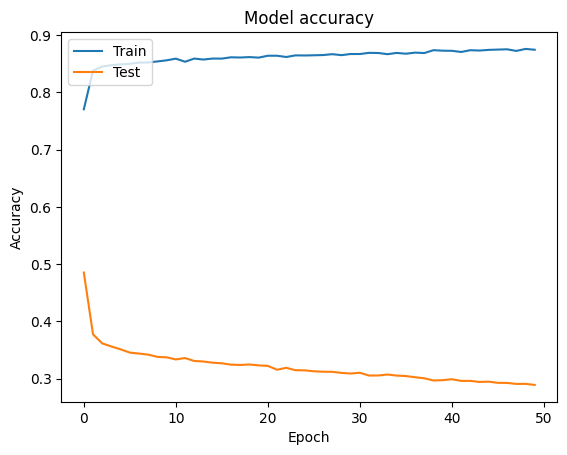

In [45]:
# On va entraîner le modèle avec les données resamplées.
# history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.1)
history = model.fit(X_resampled, y_resampled, epochs=50, batch_size=128, validation_data=(X_test_pad, y_test))

# On va afficher les résultats de l'entraînement (accuracy et loss)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [46]:

# On affiche les matrices de confusion pour chaque label.

for label in labels:
    y_pred = model.predict(X_test_pad)
    y_pred = (y_pred > 0.5).astype(int)
    print(confusion_matrix(y_test[label], y_pred))
    print(classification_report(y_test[label], y_pred))

998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
[[25501  3358]
 [  462  2594]]
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     28859
           1       0.44      0.85      0.58      3056

    accuracy                           0.88     31915
   macro avg       0.71      0.87      0.75     31915
weighted avg       0.93      0.88      0.90     31915



0.5759325044404974
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


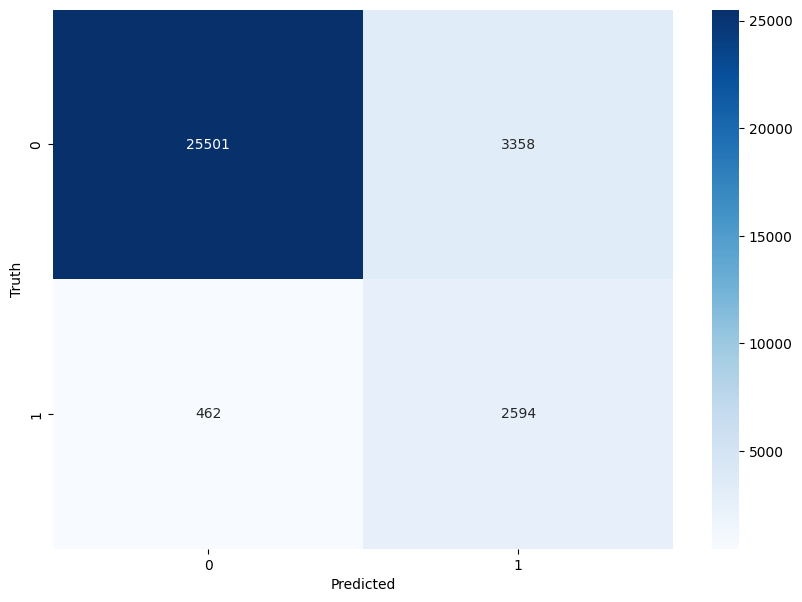

In [47]:
# Plot confusion matrix

for label in labels:
    # F1 score
    print(f1_score(y_test[label], y_pred))

    y_pred = model.predict(X_test_pad)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(y_test[label], y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()